In [6]:
import math
import scipy
import lifelines
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import fmin
from scipy.stats import weibull_min
from lifelines.datasets import load_dd

c:\users\ankushukla\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in power
  


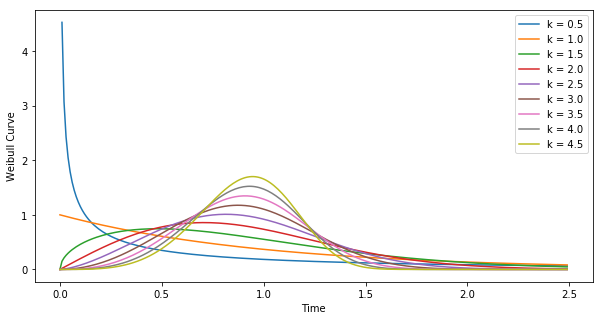

In [36]:
t = np.arange(0, 2.5, 0.01)
f, ax = plt.subplots(1, 1, figsize = (10, 5))
lamda = 1
ks = np.arange(0.5, 5, 0.5)
for k in ks:
    weibull = lambda x: np.power(x/lamda, k-1)*math.exp(-1*np.power(x/lamda, k))*(k/lamda)
    vect_weibull = np.vectorize(weibull)
    distribution = vect_weibull(t)
    w = sns.lineplot(x = t, y = distribution, ax = ax, label = 'k = {}'.format(k))
w.set_ylabel('Weibull Curve')
w.set_xlabel('Time')
plt.legend()
plt.show()

In [15]:
from lifelines import WeibullFitter

In [5]:
def fitweibull_uncensored(t):
    def optfun(theta):
        return -np.sum(np.log(theta[0]/theta[1]) + (theta[0] - 1)*np.log(t/theta[1]) - np.power(t/theta[1], theta[0]))
    
    logx = np.log(t)
    shape = 1.2 / np.std(logx)
    scale = np.exp(np.mean(logx) + (0.572 / shape))
   
    return fmin(optfun, [shape, scale], xtol = 0.01, ftol = 0.01, disp = 0)

def fitweibull_censored(t, u):
    def optfun(theta):
        return -np.sum(np.log(theta[0]/theta[1]) + (theta[0] - 1)*np.log(t/theta[1]) - np.power(t/theta[1], theta[0])) + np.sum(np.power(u/theta[1], theta[0]))
    
    logx = np.log(t)
    shape = 1.2 / np.std(logx)
    scale = np.exp(np.mean(logx) + (0.572 / shape))
   
    return fmin(optfun, [shape, scale], xtol = 0.01, ftol = 0.01, disp = 0)
    
def weibull_mle_estimation(df, censored = False):
    if(censored):
        theta = fitweibull_censored(df[df['censored'] == 0]['duration'], df[df['censored'] == 1]['duration'])
    else:
        theta = fitweibull_uncensored(df['duration'])
    
    return theta

def cdf(theta, t):
    beta, alpha = theta
    return np.exp(-np.power(t/alpha, beta))

In [7]:
df = load_dd()
df.head()

ctryname  cowcode2  politycode un_region_name un_continent_name  \
0  Afghanistan       700       700.0  Southern Asia              Asia   
1  Afghanistan       700       700.0  Southern Asia              Asia   
2  Afghanistan       700       700.0  Southern Asia              Asia   
3  Afghanistan       700       700.0  Southern Asia              Asia   
4  Afghanistan       700       700.0  Southern Asia              Asia   

                   ehead                                     leaderspellreg  \
0    Mohammad Zahir Shah  Mohammad Zahir Shah.Afghanistan.1946.1952.Mona...   
1  Sardar Mohammad Daoud  Sardar Mohammad Daoud.Afghanistan.1953.1962.Ci...   
2    Mohammad Zahir Shah  Mohammad Zahir Shah.Afghanistan.1963.1972.Mona...   
3  Sardar Mohammad Daoud  Sardar Mohammad Daoud.Afghanistan.1973.1977.Ci...   
4    Nur Mohammad Taraki  Nur Mohammad Taraki.Afghanistan.1978.1978.Civi...   

       democracy         regime  start_year  duration  observed  
0  Non-democracy       Monarchy        1946         7         1  
1  Non-democracy  Civilian Dict        1953        10         1  
2  Non-democracy       Monarchy        1963        10         1  
3  Non-democracy  Civilian Dict        1973         5         0  
4  Non-democracy  Civilian Dict        1978         1         0

In [8]:
df.loc[:, 'censored'] = 1 - df['observed']

In [9]:
uncensored = df[df['censored'] == 0]

In [18]:
theta = weibull_mle_estimation(uncensored)
theta

array([1.04285609, 4.4065594 ])

In [16]:
wbf = WeibullFitter()

In [20]:
T = uncensored["duration"]
E = uncensored["observed"]

wbf.fit(T, event_observed=E)

<lifelines.WeibullFitter: fitted with 1468 observations, 0 censored>

In [21]:
wbf.summary

coef  se(coef)  lower 0.95  upper 0.95              p    -log2(p)
lambda_  4.408714  0.117248    4.178912    4.638516  7.948367e-186  614.887967
rho_     1.042972  0.019398    1.004952    1.080993   2.674271e-02    5.224710

In [82]:
theta = weibull_mle_estimation(df, censored = True)
theta

array([0.94210443, 6.1086378 ])

In [24]:
T = df["duration"]
E = df["observed"]

wbf.fit(T, event_observed=E)

<lifelines.WeibullFitter: fitted with 1808 observations, 340 censored>

In [25]:
wbf.summary

coef  se(coef)  lower 0.95  upper 0.95              p    -log2(p)
lambda_  6.110227  0.171868    5.773371    6.447082  2.840691e-194  642.947808
rho_     0.942647  0.017991    0.907386    0.977909   1.433366e-03    9.446377

In [38]:
k, lamda = theta

In [69]:
theta2 = [0.942647, 6.110227]

In [83]:
t = np.array(wbf.survival_function_['Weibull_estimate'].index.values)
vect_s = np.vectorize(lambda x: cdf(theta, x))
s = vect_s(t)

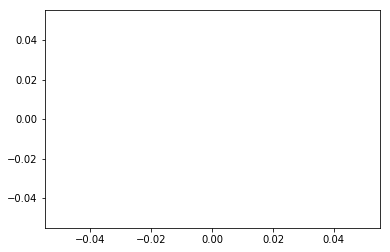

In [58]:
f, ax = plt.subplots(1, 1)
plt.plot(x = t, y = s, label = 'MLE')
# ax.plot(x = t, y = wbf.survival_function_['Weibull_estimate'].values, label = 'Lifelines')
plt.show()

In [43]:
wbf.survival_function_['Weibull_estimate'].values

array([0.83396648, 0.83034352, 0.82674143, ..., 0.00107476, 0.00107102,
       0.00106728])

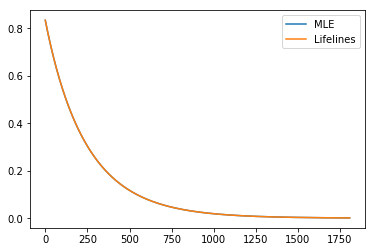

In [84]:
plt.plot(s, label = 'MLE')
plt.plot(wbf.survival_function_['Weibull_estimate'].values, label = 'Lifelines')
plt.legend()
plt.show()